In [1]:
!pip install praw

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.8/188.8 KB 7.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 KB 7.4 MB/s eta 0:00:00


In [2]:
import praw
import pandas as pd

# Creating Application for Reddit

In [3]:
user_agent = "Test API 1"

# defining instances
reddit = praw.Reddit(
    client_id = "KUivSj_mwwz7tZe9-tR8eA",
    client_secret = "Bl4xX0C1ad0h2RzngPvzCjgThveCyg",
    user_agent = user_agent,
    check_for_async = False
)

# Extracting Posts from Reddit

In [4]:
subreddit_name = "macbook"
subreddit = reddit.subreddit(subreddit_name)

print(subreddit.display_name)

macbook


In [5]:
titles=[]
scores=[]
ids=[]

for submission in subreddit.top(limit=50):
    titles.append(submission.title)
    scores.append(submission.score) # upvotes
    ids.append(submission.id)

In [6]:
df = pd.DataFrame()

df['Title'] = titles
df['Id'] = ids
df['Upvotes'] = scores # upvotes

print(df.head(10))

                                               Title       Id  Upvotes
0  Got accepted into medical school and my parent...   pxwnp7     1115
1         Goodbye surface “pro” 7, hello bankruptcy.   mx7tuf      864
2  Surprised my girlfriend with a MacBook Air for...   aevd2n      743
3  Unpopular Opinion / Rant: This subreddit has b...   o0wa4d      629
4                          Loving my new retro skins   go8ylr      612
5                                   So many macbooks  10zha2d      606
6  Upgraded! From 2006 Intel MacBook Pro to 2020 ...   kc079r      568
7                      MacBook pro 16 m1pro unboxed.   qe8yxp      548
8                                          The M1 rn   jzphvx      514
9  🤦‍♂️ All these M1 posts are having me regret b...   kxlin5      502


# Preprocessing

In [7]:
!pip install torchdata

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.6/4.6 MB 58.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.6/140.6 KB 15.0 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3


In [8]:
!python -m spacy download en_core_web_md

2023-02-25 06:34:06.473300: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-25 06:34:07.907488: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 06:34:07.907639: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/lib64-nvidia
2023-02-25 06:34:07.907660: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT War

In [9]:
import torch, torchdata, torchtext
from torch import nn

SEED = 1234
torch.manual_seed(SEED)

In [10]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [11]:
from torchtext.datasets import SST2
train = SST2(split='train')

In [12]:
from torchtext.data.utils import get_tokenizer

tokenizer = get_tokenizer('spacy', language='en_core_web_md')

In [13]:
from torchtext.vocab import build_vocab_from_iterator

def yield_tokens(data_iter):  # data_iter, e.g., train
    for text, _  in data_iter:
        yield tokenizer(text)
        
vocab = build_vocab_from_iterator(yield_tokens(train), specials=['<unk>', '<pad>',
                                                                 '<bos>', '<eos>'])

In [14]:
vocab.set_default_index(vocab["<unk>"]) 

In [15]:
id2word = vocab.get_itos()

In [16]:
pad_idx = vocab['<pad>']

In [17]:
text_pipeline  = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

# Modeling

In [18]:
class LSTM(nn.Module):
    
    def __init__(self, input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, 
                 dropout):
        super().__init__()
        # input dim = how many vocab we have
        # emb dim = 300 --> we use fasttext
        # padding_idx tells this lookup table to ignore, and just randomize....
        # <unk>, <bos>, <eos>
        self.embedding_layer = nn.Embedding(input_dim, emb_dim, padding_idx=pad_idx)
        self.lstm            = nn.LSTM(emb_dim,
                                       hid_dim,
                                       num_layers = num_layers,
                                       bidirectional = bidirectional,
                                       dropout = dropout,  # dropout is applied between layers....
                                       batch_first=True)
        
        self.fc              = nn.Linear(hid_dim * 2, output_dim)
        
    def forward(self, x, lengths):
        # x: [batch size, seq len]
        
        embedded_x = self.embedding_layer(x)
        # x: [batch size, seq len, emb dim]
        
        # pack this embedded_x in such a way that RNN knows to ignore padding....
        # without batch_first = True; things will become [seq len, batch size, emb dim]
        pack_embedded = nn.utils.rnn.pack_padded_sequence(embedded_x, lengths.to('cpu'),
                                                          enforce_sorted=False,
                                                          batch_first = True
                                                          )
        
        # packed_outputs is basically all hidden states
        # h is the last hidden state
        # c is the last cell state
        packed_outputs, (h, _) = self.lstm(pack_embedded)
        
        # h: [num_layers * num_directions, batch_size, hidden dim]
        
        # it happens that because packed_outputs is all hidden states....some hidden states near the end is
        # hidden state for padding, pytorch guys help you
        # by using this pad_packed_sequence, then all the hidden states will only be not padding....
        output, output_lengths = nn.utils.rnn.pad_packed_sequence(packed_outputs, batch_first = True)
        # output: [batch size, seq len, direction * hidden sim]
        
        # last hidden state - concat last forward and backward states
        last_hidden_state = torch.cat((h[-1, :, :], h[-2, :, :]), dim = 1)
        # last_hidden_state: [batch_size, hidden_dim * 2]
        
        # for sentiment analysis.....what should i sent to my linear layer...
        return self.fc(last_hidden_state)  # [batch_size, output_dim]==> [batch_size, 4]

In [19]:
input_dim  = 13767 # len(vocab)
hid_dim    = 256
emb_dim    = 300
output_dim = 2

#for biLSTM
num_layers = 2
bidirectional = True
dropout = 0.2

model = LSTM(input_dim, emb_dim, hid_dim, output_dim, num_layers, bidirectional, dropout).to(device)

# Loading the Model

In [20]:
path = f'{model.__class__.__name__}.pt'
# model.load_state_dict(torch.load(path, map_location=torch.device('cpu')))

In [22]:
if next(model.parameters()).is_cuda:
    model = model.cpu()

# Checking Posts and Sentiments 

In [23]:
def predict(text, text_length):
    with torch.no_grad():
        output = model(text, text_length).squeeze(1)
        predicted = torch.max(output.data, 1)[1]
        return predicted

In [24]:
sentiment = []

for title in titles:
    text = torch.tensor(text_pipeline(title))
    text = text.reshape(1, -1)
    text_length = torch.tensor([text.size(1)]).to(dtype=torch.int64)
    senti_pred = predict(text, text_length)
    sentiment.append(int(senti_pred[0]))

In [25]:
pred = pd.DataFrame()

pred['Title'] = titles
pred['Sentiment'] = sentiment

print(pred)

                                                Title  Sentiment
0   Got accepted into medical school and my parent...          0
1          Goodbye surface “pro” 7, hello bankruptcy.          0
2   Surprised my girlfriend with a MacBook Air for...          0
3   Unpopular Opinion / Rant: This subreddit has b...          0
4                           Loving my new retro skins          1
5                                    So many macbooks          0
6   Upgraded! From 2006 Intel MacBook Pro to 2020 ...          0
7                       MacBook pro 16 m1pro unboxed.          0
8                                           The M1 rn          0
9   🤦‍♂️ All these M1 posts are having me regret b...          0
10                                      All the time.          1
11         Mac with extend Monitor - Nice combination          0
12  Wasn’t a fan of apple products but everything ...          0
13                                We are not the same          0
14                       

# Plotting the Count of Positive and Negative Posts

<BarContainer object of 2 artists>

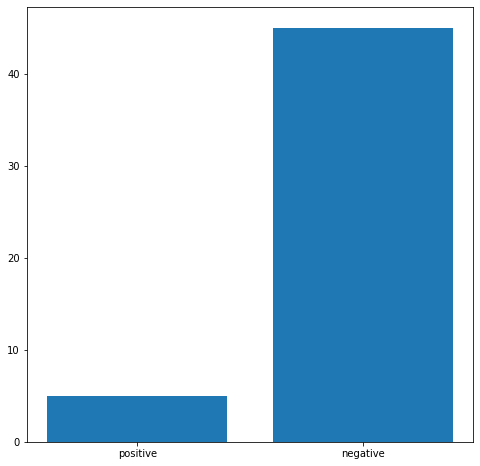

In [32]:
import matplotlib.pyplot as plt

sentiment_count = {"positive": 0, "negative": 0}
for senti in sentiment:
    if senti == 1:
        sentiment_count["positive"] += 1
    else:
        sentiment_count["negative"] += 1

labels = list(sentiment_count.keys())
count  = list(sentiment_count.values())

plt.figure(figsize = (8, 8))
plt.bar(labels, count)

# Top Words inside Positive and Negative Comments

In [33]:
pos_word_count = {}
neg_word_count = {}

def incr_word_count(text, word_count):
    if text in word_count:
        word_count[text] += 1
    else:
        word_count[text] = 1

for idx in range(len(pred)):
    text_list  = tokenizer(pred["Title"][idx])
    senti_pred = pred["Sentiment"][idx]
    
    for text in text_list:
        text = text.lower()
        
        if senti_pred == 1:
            incr_word_count(text, pos_word_count)
        elif senti_pred == 0:
            incr_word_count(text, neg_word_count)

In [34]:
# positive words
sorted_pos_word_count = dict(sorted(pos_word_count.items(), key=lambda item: item[1]))

In [35]:
print("Top words inside positive posts:")
print(list(sorted_pos_word_count.keys())[-10:])

Top words inside positive posts:
['you', 'might', 'like', 'this', 'white', 'my', 'new', 'the', 'macbook', '.']


In [37]:
# negative words
sorted_neg_word_count = dict(sorted(neg_word_count.items(), key=lambda item: item[1]))

In [38]:
print("Top words inside negative posts:")
print(list(sorted_neg_word_count.keys())[-10:])

Top words inside negative posts:
['a', 'air', 'i', '!', 'my', 'm1', ',', 'the', '.', 'macbook']


In [39]:
print("Top words inside negative posts:")
print(list(sorted_neg_word_count.keys())[-20:])

Top words inside negative posts:
['?', 'first', 'got', 'and', 'for', 'me', 'this', 'pro', 'it', 'in', 'a', 'air', 'i', '!', 'my', 'm1', ',', 'the', '.', 'macbook']
